# <center>Project 2: Gun Analysis in California<br><span style="font-size: 12px">Udacity Data Analytic Nanodegree Project 2 - Investigate a Dataset</span></center>

## Table of Contents<a id='toc'></a>
* <a href="#intro">Introduction</a>
* <a href="#wrangling">Data Wrangling</a>
    * <a href="#f1">Data Cleaning File 'gun_data.xlsx'</a>
    * <a href="#f2">Data Cleaning File 'U.S. Census Data.csv'</a>  
* <a href="#eda">Exploratory Data Analysis</a>
    * <a href="#q1">Q1: How Many Permits are Issued for Each Type of Gun in California?</a>
    * <a href="#q2">Q2: What is the trend of gun permit and background checks in California?</a>
    * <a href="#q3">Q3: How is The Growth of Gun Permit  in Relationship to the Growth of The Population?</a>
* <a href="#conclusions">Conclusions</a>
* <a href="#resources">Resources</a>

## Introduction <a id='intro'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

The goal of this analysis is to take a deeper look into the gun permits issuing in California and whether it is related to the growth of the population. For this analysis, two datasets are used:
1. 'gun_data.xlsx': This data comes from the FBI's National Instant Criminal Background Check System (NICS). It is used to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. It contains the number of firearm checks by month, state, and type.
2. 'U.S. Census Data.csv': This is the U.S. census data. It contains several variables at the state level.

**Analysis Questions**
1. How Many Permits are Issued for Each Type of Gun in California?
2. What is the trend of gun permit and background checks in California?
3. How is The Growth of Gun Permit  in Relationship to the Growth of The Population?

## Data Wrangling <a id='wrangling'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [1268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data Cleaning File 'gun_data.xlsx' <a id="f1"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [1269]:
# Read in NICS data and convert dates to datetime object
df_guns = pd.read_excel('gun_data.xlsx', parse_dates=[0])
df_guns.shape

(12485, 27)

In [1270]:
df_guns.head(2)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09-01,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09-01,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303


In [1271]:
# Selecte only interested columns and row for "Californa"
df_guns_cal = df_guns.iloc[:, [0,1,2,4,5,6,7,26]]
df_guns_cal = df_guns_cal.loc[df_guns.state == 'California']

df_guns_cal.reset_index(inplace=True, drop=True)
df_guns_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   month     227 non-null    datetime64[ns]
 1   state     227 non-null    object        
 2   permit    227 non-null    float64       
 3   handgun   227 non-null    float64       
 4   long_gun  227 non-null    float64       
 5   other     100 non-null    float64       
 6   multiple  227 non-null    int64         
 7   totals    227 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 14.3+ KB


In [1272]:
# Convert 'tatals' column to float datatype
df_guns_cal['totals'] = df_guns_cal['totals'].astype(float)
df_guns_cal.totals.info()

<class 'pandas.core.series.Series'>
RangeIndex: 227 entries, 0 to 226
Series name: totals
Non-Null Count  Dtype  
--------------  -----  
227 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


### Data Cleaning File 'U.S. Census Data.csv' <a id="f2"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [1273]:
df_census = pd.read_csv('U.S. Census Data.csv')
df_census.shape

(85, 52)

In [1274]:
# Select census data for California
df_census_cal = df_census.loc[:, ['Fact','California']]
df_census_cal

,Fact,California
0,"Population estimates, July 1, 2016, (V2016)","39,250,017"
1,"Population estimates base, April 1, 2010, (V2...","37,254,522"
2,"Population, percent change - April 1, 2010 (es...",5.40%
3,"Population, Census, April 1, 2010","37,253,956"
4,"Persons under 5 years, percent, July 1, 2016, ...",6.30%
...,...,...
80,FN,NaN
81,NaN,NaN
82,S,NaN
83,X,NaN


In [1275]:
# Remove rows with NaN
df_census_cal.dropna(inplace=True)
df_census_cal

,Fact,California
0,"Population estimates, July 1, 2016, (V2016)","39,250,017"
1,"Population estimates base, April 1, 2010, (V2...","37,254,522"
2,"Population, percent change - April 1, 2010 (es...",5.40%
3,"Population, Census, April 1, 2010","37,253,956"
4,"Persons under 5 years, percent, July 1, 2016, ...",6.30%
...,...,...
60,"Veteran-owned firms, 2012","252,377"
61,"Nonveteran-owned firms, 2012","3,176,341"
62,"Population per square mile, 2010",239.1
63,"Land area in square miles, 2010","155,779.22"


In [1276]:
# Select only rows contain population
df_census_cal_pop = df_census_cal.loc[
    df_census_cal.Fact.str.contains('Population estimates') | 
    df_census_cal.Fact.str.contains('Population, Census')].copy(deep=True)
df_census_cal_pop.reset_index(inplace=True, drop=True)
df_census_cal_pop

,Fact,California
0,"Population estimates, July 1, 2016, (V2016)","39,250,017"
1,"Population estimates base, April 1, 2010, (V2...","37,254,522"
2,"Population, Census, April 1, 2010","37,253,956"


In [1277]:
# Check data in the Fact column
df_census_cal_pop.Fact.unique()

array(['Population estimates, July 1, 2016,  (V2016)',
       'Population estimates base, April 1, 2010,  (V2016)',
       'Population, Census, April 1, 2010'], dtype=object)

In [1278]:
# Add a column for date
mask = df_census_cal_pop.Fact.str.contains('July 1, 2016')
df_census_cal_pop.loc[mask, 'date'] = datetime.datetime(2016, 7, 1)

mask = df_census_cal_pop.Fact.str.contains('April 1, 2010')
df_census_cal_pop.loc[mask, 'date'] = datetime.datetime(2010, 4, 1)

df_census_cal_pop

,Fact,California,date
0,"Population estimates, July 1, 2016, (V2016)","39,250,017",2016-07-01
1,"Population estimates base, April 1, 2010, (V2...","37,254,522",2010-04-01
2,"Population, Census, April 1, 2010","37,253,956",2010-04-01


In [1279]:
# Change the number strings to float
df_census_cal_pop['California'] = df_census_cal_pop['California'].str.replace(',','')
df_census_cal_pop['California'] = df_census_cal_pop['California'].str.replace('%','')
df_census_cal_pop['California'] = df_census_cal_pop.California.astype('float')
df_census_cal_pop['California'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3 entries, 0 to 2
Series name: California
Non-Null Count  Dtype  
--------------  -----  
3 non-null      float64
dtypes: float64(1)
memory usage: 152.0 bytes


In [1280]:
df_census_cal_pop

,Fact,California,date
0,"Population estimates, July 1, 2016, (V2016)",39250017.0,2016-07-01
1,"Population estimates base, April 1, 2010, (V2...",37254522.0,2010-04-01
2,"Population, Census, April 1, 2010",37253956.0,2010-04-01


## Exploratory Data Analysis <a id='eda'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

### Q1: How Many Permits are Issued for Each Type of Gun in California? <a id="q1"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [1281]:
# Remove year 2017 rows, it doesn't contain a full year data; contain only up to September 2017
rows_2017 = df_guns_cal[df_guns_cal.month.dt.year == 2017].index
df_guns_cal.drop(rows_2017, inplace=True)

df_guns_cal.head(3)

,month,state,permit,handgun,long_gun,other,multiple,totals
9,2016-12-01,California,61808.0,63649.0,93224.0,77929.0,0,298161.0
10,2016-11-01,California,53278.0,56932.0,82554.0,30133.0,0,224039.0
11,2016-10-01,California,60578.0,45785.0,54333.0,19226.0,0,180968.0


In [1282]:
# Remove year 1998 rows, it doesn't contain a full year data; only contain Nov and Dec data
rows_1998 = df_guns_cal[df_guns_cal.month.dt.year == 1998].index
df_guns_cal.drop(rows_1998, inplace=True)

df_guns_cal.tail(3)

,month,state,permit,handgun,long_gun,other,multiple,totals
222,1999-03-01,California,7591.0,32639.0,28097.0,NaN,0,68327.0
223,1999-02-01,California,5715.0,27909.0,23847.0,NaN,0,57471.0
224,1999-01-01,California,7311.0,25989.0,23653.0,NaN,0,56953.0


In [1283]:
# Rename column 'totals' to 'background_check'
df_guns_cal.columns = ['month', 'state', 'permit', 'handgun', 'long gun', 'other', 'multiple', 'background check']
df_guns_cal.head(3)

,month,state,permit,handgun,long gun,other,multiple,background check
9,2016-12-01,California,61808.0,63649.0,93224.0,77929.0,0,298161.0
10,2016-11-01,California,53278.0,56932.0,82554.0,30133.0,0,224039.0
11,2016-10-01,California,60578.0,45785.0,54333.0,19226.0,0,180968.0


In [1284]:
# Fill NaN with mean
df_guns_cal.other = df_guns_cal.other.fillna(df_guns_cal.other.mean())
df_guns_cal.tail(3)

,month,state,permit,handgun,long gun,other,multiple,background check
222,1999-03-01,California,7591.0,32639.0,28097.0,3479.384615,0,68327.0
223,1999-02-01,California,5715.0,27909.0,23847.0,3479.384615,0,57471.0
224,1999-01-01,California,7311.0,25989.0,23653.0,3479.384615,0,56953.0


In [1285]:
df_guns_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 9 to 224
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   month             216 non-null    datetime64[ns]
 1   state             216 non-null    object        
 2   permit            216 non-null    float64       
 3   handgun           216 non-null    float64       
 4   long gun          216 non-null    float64       
 5   other             216 non-null    float64       
 6   multiple          216 non-null    int64         
 7   background check  216 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 13.6+ KB


In [1286]:
# Aggregate gun data by year
df_guns_grp = df_guns_cal.groupby([df_guns_cal['month'].dt.year.rename('year')]).sum()
df_guns_grp.reset_index(inplace=True)
df_guns_grp.head(3)

,year,permit,handgun,long gun,other,multiple,background check
0,1999,101132.0,371893.0,410119.0,41752.615385,0,883144.0
1,2000,163145.0,328615.0,302746.0,41752.615385,0,794506.0
2,2001,236271.0,280044.0,338251.0,41752.615385,0,854569.0


In [1287]:
# Change the dataframe to a long form for plotting
df_guns_melted = pd.melt(df_guns_grp, id_vars=["year"], value_vars=['handgun', 'long gun', 'other', 'multiple'],
                        var_name='types', value_name='total')
df_guns_melted.head(3)

,year,types,total
0,1999,handgun,371893.0
1,2000,handgun,328615.0
2,2001,handgun,280044.0


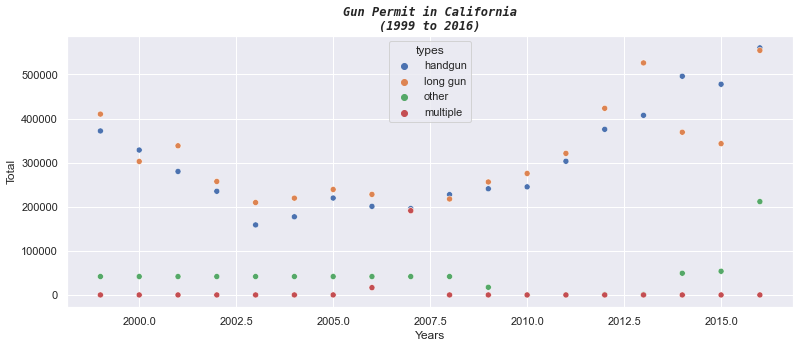

In [1314]:
fig , ax = plt.subplots(figsize=(13,5))
sns.scatterplot(data=df_guns_melted, y='total', x='year', hue='types', ax=ax);

title = ['Gun Permit in California', '(1999 to 2016)',]
ax.set_title(
    '\n'.join(title),
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace');

ax.set_xlabel(
    'Years', 
    fontsize='large');

ax.set_ylabel(
    'Total', 
    fontsize='large');

### Q2: What is the trend of gun permit and background checks in California? <a id='q2'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [1289]:
# Melt permit and background checks for plotting
df_permit_melted = pd.melt(df_guns_grp, id_vars=["year"], value_vars=['permit', 'background check'],
                        var_name='types', value_name='total')
df_permit_melted.head(3)

,year,types,total
0,1999,permit,101132.0
1,2000,permit,163145.0
2,2001,permit,236271.0


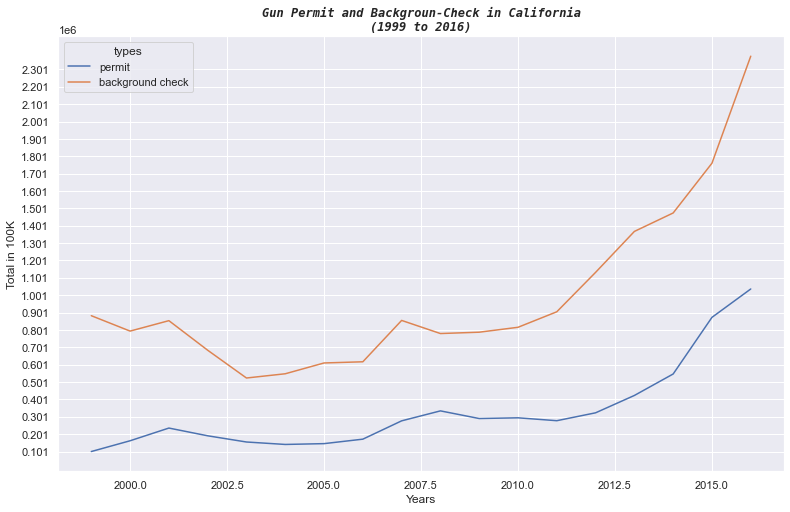

In [1315]:
# Plotting for permits and background check
fig , ax = plt.subplots(figsize=(13,8))
sns.lineplot(data=df_permit_melted, y='total', x='year', hue='types', ax=ax);

ax.set_title(
    "Gun Permit and Backgroun-Check in California\n(1999 to 2016)",
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace')
    
ax.set_xlabel(
    'Years', 
    fontsize='large')

ax.set_ylabel(
    'Total in 100K', 
    fontsize='large')

t = np.arange(df_permit_melted.total.min(), df_permit_melted.total.max(), 100000)
ax.set_yticks(t);

### Q3: How is The Growth of Gun Permit  in Relationship to the Growth of The Population? <a id="q3"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [1291]:
# California census data
df_census_cal_pop.head(3)

,Fact,California,date
0,"Population estimates, July 1, 2016, (V2016)",39250017.0,2016-07-01
1,"Population estimates base, April 1, 2010, (V2...",37254522.0,2010-04-01
2,"Population, Census, April 1, 2010",37253956.0,2010-04-01


In [1292]:
# Select population data for two months (07/2016, and 4/2010)
df_pop_2mons = df_census_cal_pop.iloc[[0,2],:]
df_pop_2mons.columns = ['fact', 'population', 'month']
df_pop_2mons

,fact,population,month
0,"Population estimates, July 1, 2016, (V2016)",39250017.0,2016-07-01
2,"Population, Census, April 1, 2010",37253956.0,2010-04-01


In [1293]:
# California gun data
df_guns_cal.head(3)

,month,state,permit,handgun,long gun,other,multiple,background check
9,2016-12-01,California,61808.0,63649.0,93224.0,77929.0,0,298161.0
10,2016-11-01,California,53278.0,56932.0,82554.0,30133.0,0,224039.0
11,2016-10-01,California,60578.0,45785.0,54333.0,19226.0,0,180968.0


In [1294]:
# Select gun data for the same two months (07/2016, and 4/2010) to compare with the population
df_rel = df_guns_cal.loc[(df_guns_cal.month=='2016-07-01') | (df_guns_cal.month=='2010-04-01')]
df_rel

,month,state,permit,handgun,long gun,other,multiple,background check
14,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0
89,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0


In [1295]:
# Merge the gun data and popolation data
df_merged = pd.merge(df_rel, df_pop_2mons, on='month')
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,fact,population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,"Population estimates, July 1, 2016, (V2016)",39250017.0
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,"Population, Census, April 1, 2010",37253956.0


In [1296]:
# Drop column 'fact'
df_merged.drop(['fact'], axis=1, inplace=True)
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,39250017.0
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,37253956.0


In [1297]:
# Add base columns for permit, backgroud check and population to compare changes from April 2010 to July 2016
df_merged['base permit'] = float(df_merged.loc[df_merged.month == '2010-04-01'].permit)
df_merged['base bg-check'] = float(df_merged.loc[df_merged.month == '2010-04-01']['background check'])
df_merged['base population'] = float(df_merged.loc[df_merged.month == '2010-04-01'].population)
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,population,base permit,base bg-check,base population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,39250017.0,26930.0,80750.0,37253956.0
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,37253956.0,26930.0,80750.0,37253956.0


In [1298]:
# Calculate the percent changes
df_merged['chng permit'] = (df_merged['permit'] - df_merged['base permit']) / df_merged['base permit'] * 100
df_merged['chng bg-check'] = (df_merged['background check'] - df_merged['base bg-check']) / df_merged['base bg-check'] * 100
df_merged['chng population'] = (df_merged['population'] - df_merged['base population']) / df_merged['base population'] * 100
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,population,base permit,base bg-check,base population,chng permit,chng bg-check,chng population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,39250017.0,26930.0,80750.0,37253956.0,189.4987,135.564087,5.357984
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,37253956.0,26930.0,80750.0,37253956.0,0.0000,0.000000,0.000000


In [1299]:
# Melt the data for plotting
df_rel_melted = pd.melt(df_merged, id_vars=["month"], value_vars=['chng permit', 'chng bg-check','chng population'],
                        var_name='types', value_name='percent').copy(deep=True)
df_rel_melted.sort_values(by=['month'], inplace=True)
df_rel_melted

,month,types,percent
1,2010-04-01,chng permit,0.000000
3,2010-04-01,chng bg-check,0.000000
5,2010-04-01,chng population,0.000000
0,2016-07-01,chng permit,189.498700
2,2016-07-01,chng bg-check,135.564087
4,2016-07-01,chng population,5.357984


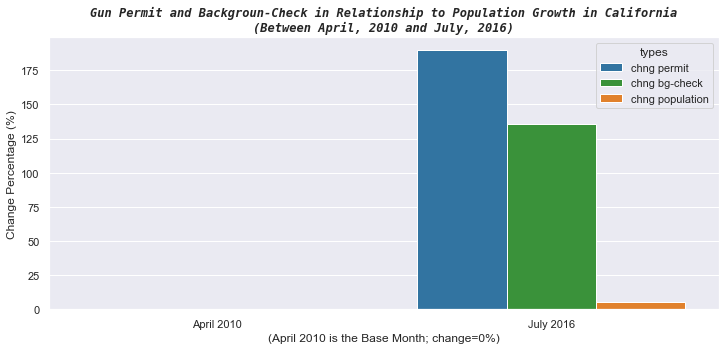

In [1317]:
# Plotting changes from moth April 2010 to July 2016
titles = ['Gun Permit and Backgroun-Check in Relationship to Population Growth in California', '(Between April, 2010 and July, 2016)']
data = df_rel_melted

palette = {
    'chng permit': 'tab:blue',
    'chng bg-check': 'tab:green',
    'chng population': 'tab:orange',
}

fig , ax = plt.subplots(figsize=(12,5))
sns.barplot(data=data, y='percent', x='month', hue='types', ax=ax, palette=palette);

ax.set_title(
    '\n'.join(titles),
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace')

ax.set_xlabel(
    '(April 2010 is the Base Month; change=0%)', 
    fontsize='large')

ax.set_ylabel(
    'Change Percentage (%)', 
    fontsize='large')

ax.set_xticklabels(['April 2010', 'July 2016']);


## Conclusions <a id='conclusions'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

><div style="font-weight:bold; color:#1976d2">1. In California, gun permit has rapidly increased by 272.18% since 2011.</div>

In [1301]:
# Calculate the change from 2011 to 2016
permit_2011 = float(df_permit_melted[(df_permit_melted.types == 'permit') & (df_permit_melted.year == 2011)].total)
permit_2016 = float(df_permit_melted[(df_permit_melted.types == 'permit') & (df_permit_melted.year == 2016)].total)
change_prct = (permit_2016 - permit_2011) / permit_2011 * 100
change_prct

272.1780170480036

><div style="font-weight:bold; color:#1976d2">2. On average, there are more permits for long gun then handgun. However, it is not consistent from year to year. Some years there are more permits for hand gun then long gun; other years there are more permits for long gun then hand gun.</div>

In [1302]:
# Calculate the average for different types of guns
mean_guns = df_guns_melted.groupby('types').total.mean()
mean_guns

types
handgun     305665.333333
long gun    315672.111111
multiple     11548.000000
other        41752.615385
Name: total, dtype: float64

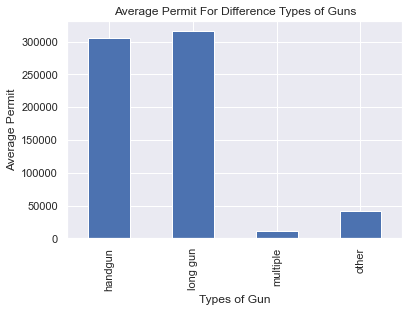

In [1303]:
# Plotting the average of difference types of gun
mean_guns.plot(kind='bar');
plt.title('Average Permit For Difference Types of Guns');
plt.ylabel('Average Permit');
plt.xlabel('Types of Gun');

><div style="font-weight:bold; color:#1976d2">3. There is no strong evidence showing the growth of population in California caused the growth of gun permit. Since the census data provides only two data point for population (April 01, 2010 and July 01, 2016), the population data from April 01, 2010 is established as the base. The percent changes is calculated between the population from July 01, 2016 and the base.<br><br>
Between April 01, 2010 and July 01, 2016, while California population only increased by 5.38%, California gun permit increased by 189.50%</div

In [1304]:
chngs = df_rel_melted[df_rel_melted.month == '2016-07-01']
chngs

,month,types,percent
0,2016-07-01,chng permit,189.498700
2,2016-07-01,chng bg-check,135.564087
4,2016-07-01,chng population,5.357984


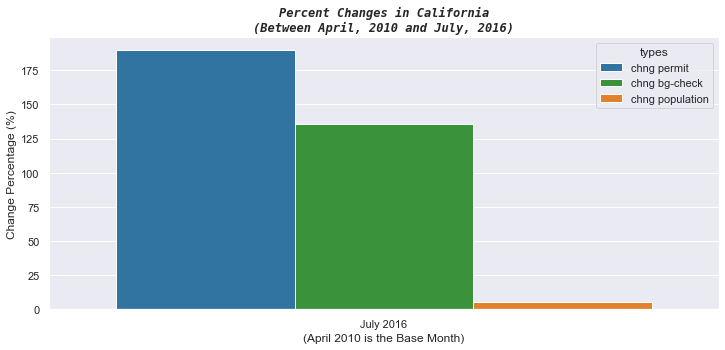

In [1305]:
# Plotting changes from moth April 2010 to July 2016
titles = ['Percent Changes in California', '(Between April, 2010 and July, 2016)']
data = chngs

palette = {
    'chng permit': 'tab:blue',
    'chng bg-check': 'tab:green',
    'chng population': 'tab:orange',
}

fig , ax = plt.subplots(figsize=(12,5))
sns.barplot(data=data, y='percent', x='month', hue='types', ax=ax, palette=palette);

ax.set_title(
    '\n'.join(titles),
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace')

ax.set_xlabel(
    '(April 2010 is the Base Month)', 
    fontsize='large')

ax.set_ylabel(
    'Change Percentage (%)', 
    fontsize='large')

ax.set_xticklabels(['July 2016']);

## Resources <a id='resources'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

1. [Panda Doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html)
2. [Seaborn Doc](https://seaborn.pydata.org/index.html)
3. [Matplotlib Doc](https://matplotlib.org/stable/plot_types/index.html)
4. [dev2qa.com](https://www.dev2qa.com/tag/python-pandas/)